# Simple SQL validator

We check for the validity of a SQL query using FSM (implemented through Python coroutines). To demonstrate the usefullness of Coroutines, we would only support following SELECT queries.

```
SELECT * from TABLE_NAME;
SELECT column, [...columns] from TABLE_NAME;
```

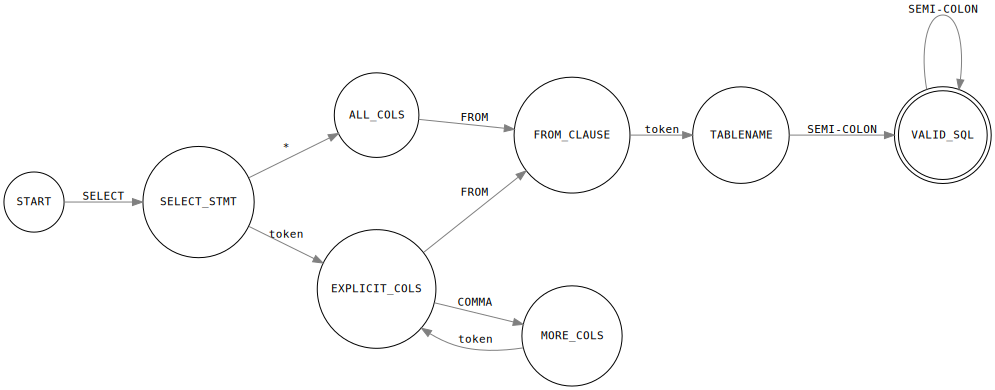

In [1]:
from graphviz import Source
with open("./sql.dot", "r") as f:
    gr = Source(f.read())
gr

In [2]:
def prime(fn):
    def wrapper(*args, **kwargs):
        v = fn(*args, **kwargs)
        v.send(None)
        return v
    return wrapper

In [3]:
class SQLValidatorFSM:
    def __init__(self):
        self.init = self._create_init()
        self.select_stmt = self._create_select_stmt()
        self.all_cols = self._create_all_cols()
        self.explicit_cols = self._create_explicit_cols()
        self.from_clause = self._create_from_clause()
        self.more_cols = self._create_more_cols()
        self.tablename = self._create_tablename()
        self.valid_sql = self._create_valid_sql()
        
        self.current_state = self.init
        self.stopped = False
        
    def send(self, token):
        try:
            self.current_state.send(token)
        except StopIteration:
            self.stopped = True
        
    def is_valid(self):
        if self.stopped:
            return False
        return self.current_state == self.valid_sql

    @prime
    def _create_init(self):
        while True:
            token = yield
            if token == "select":
                self.current_state = self.select_stmt
            else:
                break

    @prime
    def _create_select_stmt(self):
        while True:
            token = yield
            if token == "*":
                self.current_state = self.all_cols
            else:
                self.current_state = self.explicit_cols
          
    @prime
    def _create_all_cols(self):
        while True:
            token = yield
            if token == 'from':
                self.current_state = self.from_clause
            else:
                break

    @prime
    def _create_explicit_cols(self):
        while True:
            token = yield
            if token == 'from':
                self.current_state = self.from_clause
            elif token == ',':
                self.current_state = self.more_cols
            else:
                break
           
    @prime
    def _create_from_clause(self):
        while True:
            token = yield
            if token.isalnum():
                self.current_state = self.tablename
            else:
                break
           
    @prime
    def _create_more_cols(self):
        while True:
            token = yield
            if token.isalnum():
                self.current_state = self.explicit_cols
            else:
                break
             
    @prime
    def _create_tablename(self):
        while True:
            token = yield
            if token == ";":
                self.current_state = self.valid_sql
            else:
                break
            
    @prime
    def _create_valid_sql(self):
        while True:
            token = yield
            if token == ";":
                self.current_state = self.valid_sql
            else:
                break

In [4]:
def is_sql_valid(query):
    validator = SQLValidatorFSM()
    for token in query.split():
        validator.send(token)
    return validator.is_valid()

In [5]:
is_sql_valid("select * from users ;")

True

In [6]:
is_sql_valid("select id from users ;")

True

In [7]:
is_sql_valid("select id , name from users ;")

True

In [8]:
is_sql_valid("select id , name from users users ;")

False

In [9]:
is_sql_valid("update id;")

False

In [10]:
is_sql_valid("select a = 1 from users ;")

False